# __고양이 개 분류__
## 딥러닝을 이용한 이미지 분류

In [21]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models

import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import time
%matplotlib inline

In [2]:
def imshow(inp) :
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229, 0.224,0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0,1)
    plt.imshow(inp)

In [3]:
path = '/home/pirl/Joshua/PyTorch/data/dogsandcats/'

In [4]:
# 폴더 안에 모든 파일 목록을 읽음

files = glob(os.path.join(path,'*/*.jpg'))

print(f'Total no of images {len(files)}')

no_of_images = 25000
no_of_images = len(files)

Total no of images 0


In [5]:
no_of_images*0.8

0.0

In [79]:
# 데이터 집합을 만드는 데 사용할 셔플 색인 생성

shuffle = np.random.permutation(no_of_images)

In [80]:
# 검증 이미지를 저장할 검증용 디렉토리 생성
os.mkdir(os.path.join(path,'valid'))

In [81]:
# 레이블명으로 디렉토리 생성

for t in ['train','valid'] :
    for folder in ['dog/','cat/']:
        os.mkdir(os.path.join(path,t,folder))

In [67]:
folder = files[i].split('/')[-1].split('.')[0]
folder

'dog'

In [54]:
image = files[i].split('/')[-1];image

'dog.2647.jpg'

In [82]:
# valid 폴더에 이미지 2000장 복사

for i in shuffle[:2000]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'valid',folder,image))



In [85]:
# train 폴더에 이미지 2000장 복사

for i in shuffle[2000:]:
    #shutil.copyfile(files[i],'../chapter3/dogsandcats/valid/')
    folder = files[i].split('/')[-1].split('.')[0]
    image = files[i].split('/')[-1]
    os.rename(files[i],os.path.join(path,'train',folder,image))



## GPU 가용상태 확인

In [6]:
if torch.cuda.is_available():
    is_cuda = True

In [7]:
torch.cuda.is_available()

True

In [8]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train = ImageFolder('/home/pirl/Joshua/PyTorch/data/dogsandcats/train/',simple_transform)
valid = ImageFolder('/home/pirl/Joshua/PyTorch/data/dogsandcats/valid/',simple_transform)

---
* class_to_idx : 데이터 셋에서 사용하는 각 분류 클래스와 대응되는 인덱스 정보를 제공
+ classes : 분류 클래스 목록을 제공
---

In [9]:
print(train.class_to_idx)
print(train.classes) 


{'cat': 0, 'dog': 1}
['cat', 'dog']


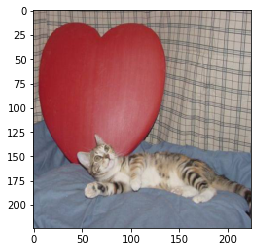

In [10]:
imshow(train[50][0])

## 배치 처리 형태 파이토치로 Tensor 로딩하기

#### DataLoader 클래스는 많은 옵션을 제공
- shuffle : True로 설정하면 DataLoader가 호출될 때 마다 이지가 임의의 순서로 섞인다.
- num_workers : 병렬 처리를 담당. 일반적으로 컴퓨터에서 사용할 수 있는 코어 수보다 작게 설정

In [28]:
train_data_gen = torch.utils.data.DataLoader(train,shuffle=True,batch_size=64,num_workers=3)
valid_data_gen = torch.utils.data.DataLoader(valid,batch_size=64,num_workers=3)

In [29]:
dataset_sizes = {'train':len(train_data_gen.dataset),'valid':len(valid_data_gen.dataset)}

In [30]:
dataloaders = {'train':train_data_gen,'valid':valid_data_gen}

## 모델 설정 네트워크 만들기

In [15]:
model_ft = models.resnet18(pretrained=True) # Resnet 알고리즘의 인스턴스를 생성
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if is_cuda :
    model_ft = model_ft.cuda()

- resnet18()에서 pretrained=True 설정 시 ImageNet의 미리 학습한 가중치가 설정된다.

In [16]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 지금 진행하는 분류 문제는 2가지(개와 고양이)만 분류하는 것이기 때문에 
- 선형레이어인 ResNet 모델의 마지막 레이어의 출력 Feature를 2로 변경한다.

In [33]:
model_ft.fc = nn.Linear(num_ftrs, 2)
if is_cuda :
    model_ft = model_ft.cuda()

## 모델 학습

In [23]:
# 오차 함수와 옵티마이저

learning_rate = 0.001
criterion = nn.CrossEntropyLoss() # 오차함수 생성
# Stochastic Gradient Descent 기반 옵티마이저 생성
optimizer_ft = optim.SGD(model_ft.parameters(),lr=learning_rate,momentum=0.9)
# 학습률을 동적으로 변경하는 기능인 StepLR
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # 각 Epoch은 학습 단계와 검증 단계를 거침
        for phase in ['train','valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)
                
            running_loss = 0.0
            running_corrects = 0
            
            # 데이터 반복
            for data in dataloaders[phase]:
                # 입력 데이터 가져오기, 데이터 획득
                inputs, labels = data
                
                # 데이터를 Variable로 만듦, 데이터 래핑(Variable)
                if torch.cuda.is_available():
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                # 파라미터 기울기 초기화
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # 학습 단계에서만 수행, 역전파 + 옵티마이즈(최적화)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # 통계
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss.item() / dataset_sizes[phase]
            epoch_acc = running_corrects.item() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # 모델 복사(Deep Copy)
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Validation Accuracy : {:4f}".format(best_acc))
    
    # 최적의 모델 weights 로딩
    
    model.load_state_dict(best_model_wts)
    return model

1. 모델에 이미지를 전달하고 오차를 계산
2. 학습 단계에서 역전파를 수행, 유효성 검사/테스트 단계에서는 가중치를 업데이트 하지 않음
3. 에폭 동안 각 배치에서 발생하는 오차를 누적
4. 최상의 모델이 저장되고 검증 정확도를 인쇄

In [37]:
%%time
model_ft = train_model(model_ft,criterion,optimizer_ft,exp_lr_scheduler,num_epochs=24)

Epoch 0/23
----------
train Loss: 0.0019 Acc: 0.9581
valid Loss: 0.0010 Acc: 0.9775

Epoch 1/23
----------
train Loss: 0.0007 Acc: 0.9856
valid Loss: 0.0007 Acc: 0.9815

Epoch 2/23
----------
train Loss: 0.0005 Acc: 0.9910
valid Loss: 0.0007 Acc: 0.9845

Epoch 3/23
----------
train Loss: 0.0004 Acc: 0.9934
valid Loss: 0.0007 Acc: 0.9850

Epoch 4/23
----------
train Loss: 0.0004 Acc: 0.9933
valid Loss: 0.0007 Acc: 0.9845

Epoch 5/23
----------
train Loss: 0.0004 Acc: 0.9933
valid Loss: 0.0007 Acc: 0.9850

Epoch 6/23
----------
train Loss: 0.0004 Acc: 0.9939
valid Loss: 0.0007 Acc: 0.9835

Epoch 7/23
----------
train Loss: 0.0004 Acc: 0.9933
valid Loss: 0.0007 Acc: 0.9855

Epoch 8/23
----------
train Loss: 0.0003 Acc: 0.9942
valid Loss: 0.0007 Acc: 0.9845

Epoch 9/23
----------
train Loss: 0.0003 Acc: 0.9946
valid Loss: 0.0007 Acc: 0.9855

Epoch 10/23
----------
train Loss: 0.0003 Acc: 0.9947
valid Loss: 0.0007 Acc: 0.9855

Epoch 11/23
----------
train Loss: 0.0003 Acc: 0.9943
valid Loss